In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Input, Dense,SpatialDropout1D
from keras.layers import LSTM, Embedding
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import spacy
from sklearn.preprocessing import MaxAbsScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve
from sklearn.feature_selection import chi2, SelectKBest

Using TensorFlow backend.
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as

In [2]:
#df=pd.read_csv('https://raw.githubusercontent.com/kushalchauhan98/bcn-cnn-text-classification/master/hm_train.csv')
#df.to_csv('hm_train.csv')
df=pd.read_csv('hm_train.csv')

In [3]:
filter=df['cleaned_hm'].str.len()<=100
df=df[filter]

In [5]:
#rint(df)
y=df['predicted_category']

y = pd.get_dummies(df['predicted_category']).values
print('Shape of label tensor:', y.shape)

LABELS=sorted(df['predicted_category'].unique())

print(y)
print(LABELS)

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cleaned_hm'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['cleaned_hm'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)



Shape of label tensor: (43354, 7)
[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
['achievement', 'affection', 'bonding', 'enjoy_the_moment', 'exercise', 'leisure', 'nature']
Shape of data tensor: (43354, 250)


In [6]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Instructions for updating:
Use tf.cast instead.
Train on 35116 samples, validate on 3902 samples
Epoch 1/5
35116/35116 [==============================] - 264s 8ms/step - loss: 0.7379 - accuracy: 0.7446 - val_loss: 0.3518 - val_accuracy: 0.8775
Epoch 2/5
27968/35116 [======================>.......] - ETA: 52s - loss: 0.2650 - accuracy: 0.9109

In [19]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4336/4336 [==============================] - 10s 2ms/step
Test set
  Loss: 0.273
  Accuracy: 0.914


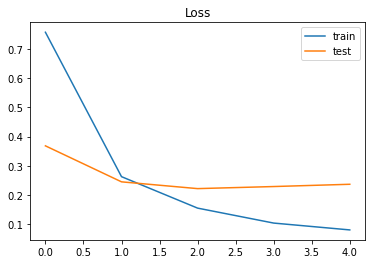

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
def GetCategory(pred,LABELS):
    returnVal=[]
    curr_index=0
    curr_val=0
    for item in pred:
        val=max(item)
        index=list(item).index(val)
        #print(val,LABELS[index])
        if val>curr_val:
            curr_index=index
            curr_val=val
            
    return LABELS[curr_index]
    #returnVal.append(LABELS[np.argmax(np.array(item))])
    #return returnVal
        
for key,item in df.iterrows():
    data=[]
    data.append(item['cleaned_hm'])
    seq = tokenizer.texts_to_sequences(data)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    print(pred)
    category=LABELS[np.argmax(pred)]
    print(data, "[predicted category]", category, "[actual category]",item['predicted_category'])
    #break
    #print(pred, LABELS[np.argmax(pred)])

[[0.14630692 0.14260684 0.14227432 0.14183347 0.14210309 0.14046647
  0.14440896]]
['I went on a successful date with someone I felt sympathy and connection with.'] [predicted category] affection [actual category] affection
[[0.13995475 0.14349107 0.14165474 0.14434688 0.1423678  0.14251453
  0.14567025]]
['I was happy when my son got 90% marks in his examination '] [predicted category] nature [actual category] affection
[[0.14179811 0.14349365 0.14317858 0.14424472 0.1416171  0.14219105
  0.1434768 ]]
['I went to the gym this morning and did yoga.'] [predicted category] achievement [actual category] exercise
[[0.1430749  0.14465012 0.14322595 0.14321753 0.14120246 0.14174801
  0.14288105]]
['I went with grandchildren to butterfly display at Crohn Conservatory\r\r\n'] [predicted category] exercise [actual category] affection
[[0.14195035 0.14659217 0.14225708 0.14472568 0.14210296 0.13956693
  0.1428048 ]]
['I meditated last night.'] [predicted category] exercise [actual category] leis

[[0.14385812 0.14476138 0.14232647 0.14409435 0.1411862  0.14184426
  0.14192922]]
['I made a bunch of extra sales in my side business last night.'] [predicted category] exercise [actual category] achievement
[[0.14279209 0.14250061 0.14119095 0.14378595 0.14130245 0.14328285
  0.14514515]]
['I walked to work and back with my partner.'] [predicted category] nature [actual category] affection
[[0.14158738 0.1437058  0.14329885 0.14236346 0.14286403 0.1429138
  0.14326671]]
['I got a promotion today after 2 years of service at my job.'] [predicted category] exercise [actual category] achievement
[[0.14547326 0.14383999 0.14329788 0.14023118 0.14312191 0.14252499
  0.14151078]]
['I woke up early in the morning at 7 am against daily of 8:30 am'] [predicted category] affection [actual category] achievement
[[0.1410383  0.14217477 0.14529587 0.14426258 0.1433092  0.14142011
  0.14249916]]
['I slow cooked a chuck roast on my stove that came out great.'] [predicted category] leisure [actual ca

['I laughed with my English class about silliness during last period.'] [predicted category] enjoy_the_moment [actual category] affection
[[0.14236018 0.14274128 0.14244391 0.14346099 0.14391258 0.14136732
  0.14371374]]
['I completed all my flashcards for an upcoming test.'] [predicted category] enjoy_the_moment [actual category] achievement
[[0.14264318 0.1451232  0.14316869 0.14373484 0.14003895 0.14094499
  0.1443462 ]]
['My daughter did very good on a big test at school. '] [predicted category] exercise [actual category] affection
[[0.14339842 0.14174272 0.14146231 0.14297377 0.1424286  0.14314795
  0.14484622]]
['I am able to sleep longer than usual'] [predicted category] nature [actual category] achievement
[[0.14174691 0.14315337 0.14100553 0.14579487 0.14167562 0.14174002
  0.14488368]]
['Yesterday solved a big issue related to family'] [predicted category] achievement [actual category] achievement
[[0.14349985 0.14301121 0.14094692 0.14361121 0.14070715 0.14315347
  0.1450702

[[0.14116398 0.14436328 0.14410308 0.14383534 0.14457676 0.14050552
  0.14145206]]
[' had a great lunch with daughter and grandchildren and enjoyed out time together'] [predicted category] enjoy_the_moment [actual category] affection
[[0.14227043 0.14581026 0.14239292 0.14160252 0.14411727 0.1419739
  0.14183268]]
['I met with my old time friends.'] [predicted category] exercise [actual category] bonding
[[0.14414199 0.14125253 0.14420529 0.14104989 0.14289252 0.14180742
  0.14465034]]
['When I weighed myself this morning, I found out I was down more weight than I thought.'] [predicted category] nature [actual category] achievement
[[0.14144075 0.14491229 0.14316492 0.1438912  0.14228818 0.14093108
  0.14337166]]
['I met my childhood friend after 10 years'] [predicted category] exercise [actual category] bonding
[[0.14075953 0.14129362 0.14259417 0.14249758 0.14383516 0.14410591
  0.144914  ]]
['GO TO HOTEL PARTY OF MY MOMS BIRTHDAY'] [predicted category] nature [actual category] enjoy

['I received a call from a new client who was ready to pay me more than usual for a simple design  '] [predicted category] bonding [actual category] achievement
[[0.14168008 0.14196256 0.14408047 0.14294876 0.14272086 0.14204027
  0.14456697]]
['I doubled my daily goal for mturk rewards in a very short amount of time.'] [predicted category] nature [actual category] achievement
[[0.14442566 0.14528689 0.14269383 0.14192043 0.13927425 0.14254606
  0.1438529 ]]
['I smoked a bowl of marijuana. '] [predicted category] exercise [actual category] leisure
[[0.14570662 0.14421572 0.14242503 0.13924316 0.14369321 0.14217325
  0.14254308]]
['I was able to eat out for dinner with one of her best friends. '] [predicted category] affection [actual category] bonding
[[0.14260696 0.14122105 0.14097185 0.14323965 0.14183317 0.1442761
  0.14585125]]
['yesterday my son want to ride my bike, when he move it he got happy....me too'] [predicted category] nature [actual category] affection
[[0.1432358  0.143

[[0.1410151  0.14212367 0.14151743 0.14543185 0.14170025 0.14291698
  0.14529474]]
['My husband bought my favourite sweet that really made me very happy'] [predicted category] achievement [actual category] affection
[[0.14232865 0.14413635 0.14243996 0.14433074 0.14094964 0.14196971
  0.14384495]]
['I finally got my drivers license.'] [predicted category] achievement [actual category] achievement
[[0.14366737 0.14369678 0.14223726 0.14108495 0.14161934 0.14298326
  0.14471105]]
["We had a really good rehearsal for Friday night's play."] [predicted category] nature [actual category] enjoy_the_moment
[[0.14278875 0.14215505 0.1422865  0.14281096 0.14197071 0.14384548
  0.14414252]]
['I made a tasty chocolate pudding, and every one enjoyed it. '] [predicted category] nature [actual category] enjoy_the_moment
[[0.14096995 0.14340231 0.14269264 0.14322214 0.14200088 0.1434958
  0.14421631]]
['My husband made me my favorite food for dinner. '] [predicted category] nature [actual category] af

In [28]:
TEXT=['cleaned_hm']
TARGET='predicted_category'
NUMERIC=[]
#def combine_text_columns(data_frame, to_drop=NUMERIC + LABELS):
def combine_text_columns(data_frame, text_labels=TEXT):
    """ converts all text in each row of data_frame to single vector """
    # Drop non-text columns that are in the df
    #to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data =data_frame[text_labels]
     
    # Replace nans with blanks
    text_data.fillna("",inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [83]:
nlp = spacy.load('en_core_web_sm')
stopwords=spacy.lang.en.stop_words.STOP_WORDS
chi_k = 300
# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

get_text_data = FunctionTransformer(combine_text_columns,validate=False)

# Preprocess the numeric data: get_numeric_data
#get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC], validate=False)

pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                #('numeric_features', Pipeline([
                #    ('selector', get_numeric_data),
                #    ('imputer', SimpleImputer())
                #])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(stop_words='english')),
                    #('vectorizer',CountVectorizer(stop_words=stopwords,token_pattern=TOKENS_ALPHANUMERIC, ngram_range=(1,2))),('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=15))),
        #('nb', MultinomialNB()),
        #('lr', OneVsRestClassifier(LogisticRegression(C=100)))
    ])

In [84]:
X=df[TEXT]
y=df[TARGET]

#print(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3, random_state=42)

pl.fit(X_train,y_train)
predictions=pl.predict(X_train)

accuracy = pl.score(X_train, y_train)
print("\nAccuracy:{:.2f}% ".format(accuracy))




Accuracy:1.00% 


In [85]:
predictions=pl.predict(X_test)

index=0
for key,item in X_test.iterrows():
    #print(item['cleaned_hm'])
    sentence=item['cleaned_hm']
    result=predictions[index]
    #actual=y_test[index]
    index+=1
    print(sentence,"[[result]]",result)

I went kayaking with my wife. [[result]] affection
I got paid from my full time job and my fun part time job. [[result]] achievement
Got my monthly pay in ny bank account. [[result]] achievement
My boyfriend and I went out to a sushi restaurant to celebrate our anniversary. [[result]] affection

 [[result]] affection
I read a few chapters in Michael Ian Black's novel "Navel Gazing." [[result]] achievement
I talked to my beloved little sister on the phone for an hour last night. [[result]] affection
My child has reported having a good week at school. [[result]] affection
I have received a bonus payment with my salary as a gift from higher officials. [[result]] achievement
i was happy last night when i went out on a blind date and he ended up being amazing [[result]] affection
I bought  ethical chocolate for a dollar each.  [[result]] enjoy_the_moment
My boyfriend proposed to me. [[result]] affection
Got engaged with my new life. [[result]] achievement
I worked outside on my lawn. [[resu

I don't have time work OT saturday so .adequate me extremely happy. [[result]] achievement
I finally got a dentist appointment after trying for a long time. [[result]] achievement
I saw a beautiful bird at my bird feeder today [[result]] nature
I went to chipotle and the server game me way more food than usual. [[result]] leisure
Last week, my best friend asked me to marry him and I said yes!  [[result]] bonding
I ate chik-fil-a [[result]] enjoy_the_moment
we celebrated our 10th wedding anniversary in last week.  [[result]] affection
I WENT TO MOVIE [[result]] leisure
I was happy listening to the NPR podcast yesterday. [[result]] leisure
I watched Masterchef Australia last night. [[result]] leisure
I had sex with a girl i met from tinder and she was amazing in bed. [[result]] affection
There was no traffic getting to the bridge to go home  [[result]] achievement
Travelling to Kuwait with my family [[result]] affection
We are going to Goa for our vacation. Tickets confirmed. [[result]] 

got into a phd program  [[result]] achievement
I had some money that was owed to me paid back to me.  [[result]] achievement
I became Facebook acquaintances with someone who shares some of my fitness interests. [[result]] achievement
found out I was accepted to UNCW. [[result]] achievement
Everyone, including my teacher, laughed at my question in German class. [[result]] achievement
Driving the van with my wife reading nearby and both kids sleeping [[result]] affection
I got a new mouse that I've been waiting to get for a really long time. [[result]] achievement
I went to a butterfly exhibit with my boyfriend yesterday. [[result]] affection
My mom discovered a new app that lets us chat on the phone. [[result]] affection
I graduated with my masters degree in February. [[result]] achievement
go to hotel,park,cinema and enjoyed as vacation [[result]] affection
I was able to cash a large check from a project I was working on. [[result]] achievement
i went to resort and enjoyed all game the

I got fast food carry-out instead of cooking because I was tired. [[result]] achievement
I watched tv with my husband. [[result]] affection
I went on a ski trip with my fiance that was really enjoyable. [[result]] affection
When the stray dog did not bite me and kept running down the street [[result]] affection
One of my neighbors attended my church because I told her about it. [[result]] bonding
I was able to pay down some credit card debt. [[result]] achievement
My son getting accepted to take the entrance exam for the vocational high school. [[result]] affection
I visited my mom after work and gave her a big hug. [[result]] affection
I spent less money in the past month than ever before. [[result]] achievement
Back on Sunday, I finished the Broad Street Run, which is a 10-mile race in Philadelphia.  [[result]] achievement
Today I finished most of the project I have been working on for two weeks.  [[result]] achievement
when my daughter took her first steps [[result]] affection
I met

My son caught the game winning pass in his football game. [[result]] affection
I planted some bulbs of my favorite flowers in my yard. [[result]] nature
Go to the mall and buy two shirts [[result]] leisure
My sister finally got a new job. [[result]] affection
I won a raffle at work and won an Ipod [[result]] achievement
I received a check in the mail for $100 from a contest i entered. [[result]] achievement
I watched my niece perform a solo at her band concert. [[result]] affection
I went to Panda Express and ordered some orange chicken with pork and fried rice. [[result]] enjoy_the_moment
I saw that it finally started raining this morning after it hasn't been raining for almost a week. [[result]] achievement
I was given free Flyers tickets and I am currently at the game having a great time. [[result]] achievement
happy birthday, my love! I love you so very much! have a special day [[result]] affection
My best friend got married last month to someone she loves dearly; they make a wonde

I watched videos of Disney World on YouTube when I got home from work. [[result]] leisure
I was happily surprised by the quality of the pizza I ordered three days ago. [[result]] affection
I ate a nice dinner.  [[result]] enjoy_the_moment
I was the winner of a random bonus. [[result]] achievement
I bought some new running shoes that are comfortable  [[result]] achievement
I got Bullet bike last month and that made me happy and I got the same color I wish to buy. [[result]] achievement
my husband promote to manager posting in our office [[result]] affection
I bought a new table. [[result]] achievement
brought a new car [[result]] achievement
getting a new car. [[result]] achievement
I made an excellent and tasty dish after doing a lot of preparation for it. [[result]] achievement
I finished spreading fertilizer on my lawn [[result]] achievement
Some neighbors came over to visit us with their kids and we all went swimming in our pool. [[result]] affection
I bought myself a new computer. 

MY HUSBAND TOOK THE KIDS AND ME TO CHUY'S (A TEX-MEX RESTAURANT) FOR DINNER. [[result]] affection
 i was happy going to lunch with my wife yesterday. [[result]] affection
I got to go to sleep early yesterday. [[result]] leisure
Dinner with my crush [[result]] affection
Receiving the news that I passed all of my classes at midterm this semester. [[result]] achievement
At work, I was thrilled to have won $40 in a small company giveaway! [[result]] achievement
My wife prepared my favorite cottage cheese dish for dinner. It felt awesome. [[result]] affection
I took Ashley to the ocean for the first time in her life, it was quite a second date. :-)  [[result]] affection
i go to old age home and service enjoy the moment. [[result]] enjoy_the_moment
Meeting my new manager. [[result]] achievement
I ate my favorite donut. [[result]] enjoy_the_moment
I was able to pay one of my important bills on time. [[result]] achievement
The team I was rooting for won their game. [[result]] achievement
I fix

I READ MY GRANDDAUGHTER ONE OF HER FAVORITE BOOKS BEFORE SHE WENT TO BED. [[result]] affection
I taught my husband how to properly load the dishwasher and he did it.  [[result]] affection
I purchased  my dream new two wheeler yesterday. This makes me too happy. [[result]] achievement
I upgraded my computer and now it looks really nice/high tech.  [[result]] achievement
I spent the day with my son on a very fun family outing. [[result]] affection
Got my lab reports back. My cholesterol was awesome.  [[result]] achievement
I managed to burn more calories than usual. [[result]] achievement
I had a big, delicious burger for dinner. [[result]] affection
I realized that my son and I actually could make it financially on our own...maybe. [[result]] affection
I was able to get all my work done on time and left earlier than expected from work.  [[result]] achievement
getting a raise [[result]] achievement
My daughter sent me an I love you text.   [[result]] affection
When I first got in top lis

A dinner of two nan and a shrimp with vegetable on linguini made me very happy.  [[result]] enjoy_the_moment
First time cooking. [[result]] achievement
I found a new job in my neighborhood after being unemployed for awhile. [[result]] achievement
We celebrated our uncles 50th birthday. [[result]] affection
Purchased a new phone today and it's up to date. I'm super excited to start using it! [[result]] affection
I got to play with my kids in the evening after supper with some building blocks. [[result]] affection
I truly decided to move forward on of dream I have. [[result]] leisure
I achieved 30 days of sobriety. [[result]] achievement
I bought a new pair of shoes.  [[result]] achievement
My girlfriend and I had a very good dinner last night - at one of our favorite restaurants. [[result]] affection
Today, I received my order purchase of my new mobile and I am very happy. [[result]] achievement
I saw my cat notice another cat outside and he freaked out, it was funny. [[result]] affecti

Got party from my friend for marriage  [[result]] bonding
I played a podcast.  [[result]] leisure
About two months ago I got a sizable raise at work that was greatly needed.  [[result]] achievement
I was able to swim 25 laps with getting overwhelmingly tired [[result]] achievement
i knew I would be able to pay my rent this month and it was a huge relief, so I was happy. [[result]] achievement
My happiest moment was when my wife baked my favorite chocolate cake after breakfast. [[result]] affection
My stocks are doing good. [[result]] achievement
I finished a project at work all by myself. [[result]] achievement
I got new glasses and my vision was so much clearer! [[result]] achievement
I was able to finish an exam that I needed to take for work. [[result]] achievement
I signed a lease renewal for our apartment after doing a little bit of searching. [[result]] achievement
I received a bonus at work for a job well done on a major project.  [[result]] achievement
I watched a movie with my

I made enough money to pay my bills [[result]] achievement
When I got some extra money for my work [[result]] achievement
The registration for my favorite event opened, and I'm really happy to go! [[result]] enjoy_the_moment
My dog was really happy to see me when I got home from work yesterday! [[result]] affection
I celebrated my 40th birthday with friends and family. [[result]] affection
Helping an old woman. [[result]] affection
Last month, I enjoyed a lot in my son's thirteenth birthday celebration. [[result]] affection
I took my wife's family out for my wife's birthday. [[result]] affection
Last month i went to hill station which looks so beautiful [[result]] achievement
My son doing well on his AP exams [[result]] affection
I officially finished my associate's degree. [[result]] achievement
I successfully resolved a misunderstanding with a vendor. [[result]] achievement
I was happy that I got a call from my sister. [[result]] affection
I bought a new home [[result]] achievement
I

1. My mom traveled across the country to visit me  [[result]] affection
Eating my favorite meal from a take out restaurant. [[result]] enjoy_the_moment
When I saw one of my  beloved after a long time. [[result]] affection
I checked my exam today and I passed with a great score. I was so grateful. [[result]] achievement
My dog came and curled up beside me while I was trying to sleep in this morning.  [[result]] affection
I started playing cricket again like in my childhood and feel so good about it [[result]] leisure
A family member brought me some good food and a few helpful items. [[result]] affection
I gave a meal to one hungry stray dog which was walking in the street around our house. [[result]] affection
My mother finally decided she wanted to take a vacation to Washington. [[result]] affection
I won my tennis singles match today against a very good player. [[result]] achievement
Phone dropped, screen protection broke and the screen itself didn't make a scratch. [[result]] achieve

I kicked the soccer ball around in the backyard with my daughter [[result]] affection
My little nephew hasn't been able to say my name.  The other day he said it perfectly. [[result]] affection
I watched a movie that I was very excited for. [[result]] leisure
I took my four children to the dentist and none of them had cavities I was so relieved and happy.  [[result]] affection
I went to a dance party and had the time of my life dancing with everyone [[result]] enjoy_the_moment
I spoke to a friend who said he would hang out with me all the time. [[result]] bonding
We moved into our new house and I love it! [[result]] achievement
Pirates Of The Caribbean 3 was on TV and I forgot how much I enjoyed the movie.  [[result]] leisure
I made, for my standards, a pretty good drawing. [[result]] achievement
Yesterday was a warm day, so I bought an early season seedless watermelon, and it was so sweet! [[result]] achievement
I got to go on a trip to New Orleans with some friends.  [[result]] bondi

Completed the installments of one of my two year investment [[result]] achievement
I was happy to see Angus emailed me back. [[result]] bonding
My nephew came down to visit me for a week during Spring Break. [[result]] affection
Watched a movie I've been wanting to see for a while. [[result]] leisure
I have saved a lot of money. [[result]] achievement
My dog greeting me at the door when I cam home after a hard day of work. [[result]] affection
I BOUGHT A NICE FANTASTIC MOBILE yesterday.that is what made my day very happy.  [[result]] achievement
The weather has been really nice today. [[result]] nature
I got to see my two brothers. [[result]] affection
A new ice cream place opened up nearby last week and I was pleasantly surprised at how good it is.  [[result]] achievement
I cut my hair the way I wanted to. [[result]] achievement
Winning the Kentucky Derby pool we had for $400 made me pretty darn happy! :-)  [[result]] achievement
performing well at basketball [[result]] achievement
I 

I helped my friends moved. [[result]] bonding
Holding our grand daughter for about 15 minutes and giving her love & kisses. [[result]] affection
Scratching off a winning lotto ticket for over 4,000 [[result]] achievement
My weekly doctor's appointment, which is a two hour drive, was reduced to only once a month. [[result]] achievement
Helped a customer at work and they were genuinely appreciative [[result]] achievement
I got a $15 return for a toy that my puppy didn't like so now I can get him one he actually does. [[result]] achievement
The sky looked beautiful one day.  [[result]] nature
Made the most perfect pattern I have ever ran on my horse! [[result]] achievement
Watching a few games of the new baseball season last night before bed. [[result]] leisure
I  went to my favorite restaurant with my best friend. [[result]] bonding
Asking my girlfriend's father for permission to marry her and his approval made me happy.  [[result]] affection
I went on a successful date with someone I fe

Getting my act together and seeing a personal trainer to get started working out.  [[result]] achievement
I purchased tickets to go watch Disney on Ice [[result]] affection
I WENT TO SHOPPING [[result]] leisure
I was able to attend the 4th birthday party of my grand daughter Violet in North Carolina. [[result]] affection
My son started walking. [[result]] affection
My girlfriend heard back from a job interview that wants to move forward. [[result]] affection
After trying to switch jobs I got a new one. [[result]] achievement
I bought a wooden baseball bat for my game tomorrow night. [[result]] achievement
I got a much larger tax refund than what I was expecting. [[result]] achievement
Sometimes I go to my boyfriend's house to have dinner and watch tv or a movie.  [[result]] affection
My nephew won his baseball game today. [[result]] affection
When i came to my home, my 4 years son hug me, as he is waiting for me. [[result]] affection
I made progress in my weightlifting and got stronger

I was able to spend time with a friend that I have not seen in months. [[result]] bonding
I was happen when my husband gave me a chocolate bar after a bad day at work. [[result]] affection
I earned a bonus card pack on a card based video game for the computer.  [[result]] achievement
I put gas in my new car yesterday, and it got an average of 48 miles per gallon!  [[result]] achievement
Visiting some family that I have not see in a while, they really wanted to. [[result]] affection
I found out that my band gets to play a huge local music festival. [[result]] leisure
Cooking a nice dinner for myself made me happy. [[result]] enjoy_the_moment
I was able to write and finish my field notes for my job successfully. [[result]] achievement
When I treat myself to a drink from Sharetea. It helps my day go by smoother.  [[result]] achievement
Drinking all last night with some really great friends! [[result]] bonding
I recently got accepted into graduate school, and it was a school that I was hop

I finished my junior year. [[result]] achievement
I WENT TO SHOPPING [[result]] leisure
It made me very happy to score three goals playing soccer with my friends. [[result]] bonding
Seeing comments on facebook about my wife [[result]] affection
I rediscovered Stevie Ray Vaughan, who plays my favorite version of Little Wing ever (sorry Jimi). [[result]] leisure
My best friend came to see me [[result]] bonding
My received second price in state level yoga competition. [[result]] achievement
my wife and i had a great date night. we don't get out much anymore, with the slow income. [[result]] affection
I went on a romantic candle night dinner with my girlfriend and we spent a quality time together. [[result]] affection
I was happy that my wife had dinner made for me when I got home. [[result]] affection
My best friend Ashlee called me and I haven't heard from her in several weeks. [[result]] bonding
I found the necklace I really wanted for a discount online. [[result]] achievement
Today is 

My sister told me that I always find the coolest and best videos for her to watch on YouTube. [[result]] affection
My mom sent me photos of her new cat. I'm glad she rescued a cat after hers passed away last year.  [[result]] affection
Tasting a meal when I was hungry.  [[result]] achievement
Sex with wife. [[result]] affection
I successfully managed our subcontractors today while my boss was off work. [[result]] achievement
My new tapestry arrived today and was far more beautiful than I had expected. [[result]] achievement
We had an awesome family trip to Great Wolf Lodge, and we enjoyed the water park. [[result]] affection
I spoke with a job recruiter regarding a new position and my resume was submitted to a new company. [[result]] achievement
I helped my younger sister decide which English courses to sign up for. [[result]] affection
I bought a new car.  [[result]] achievement
Played with our dogs, two of them. Felt really relaxed and good about myself. [[result]] affection
We went 

YESTERDAY I BOUGHT A NEW CAR.IT WAS MY LIFETIME DREAM.I FELT VERY HAPPY. [[result]] achievement
My sister had her baby! [[result]] affection
My toddler nephew blew me a kiss as I left for work this morning. [[result]] affection
Going to a puppy shop. [[result]] affection
Today, I proposed my freind and my proposal is accepted. [[result]] achievement
I bought a new pair of shoes. [[result]] achievement
The free wifi in the store now is helpful for me when I go there! [[result]] achievement
Make family travel plans for the long vacation of the next week [[result]] affection
I had a great masturbation session this morning. [[result]] leisure
I made significant progress in completing a work project. [[result]] achievement
My husband received a bonus at work.  [[result]] affection
My daughter made me a craft. [[result]] affection
My wife made me my favorite steak and she made some potatoes as well that were delicious [[result]] affection
My son was not well and suffered from ough wheeze by 

getting a good grade on my finals  [[result]] achievement
I bought a new pair of shoes at the mall. [[result]] achievement
 Watching raindrops arace each othera down windows. [[result]] enjoy_the_moment
when i bought my little brother his favorite transformer action figure. [[result]] affection
In the past three months I developed my own website from scratch  [[result]] achievement
Went to a sensory illumination event.  There was fire dancing and silk  airily dancing. [[result]] enjoy_the_moment
my boy friend give me a surprise party [[result]] bonding
When my wife told me she loved me when I woke up this morning.  [[result]] affection
I got gift from my elder brother which was really surprising me [[result]] affection
I read a funny joke. [[result]] leisure
I practiced playing the ukulele. [[result]] achievement
My  sister called me and we talked. [[result]] affection
History day came to an end [[result]] achievement
Committed new project with a reputed company [[result]] achievement


Solving an engineering mechanics problem made me happy. [[result]] achievement
My daughter got her hearing aids. [[result]] affection
I received a good bonus yesterday, for a hit that I worked last week. [[result]] achievement
I went to Hindi class. [[result]] enjoy_the_moment
I talked with my family over Facetime [[result]] affection
I took a long walk while listening on my headphones to good music and it was a beautiful afternoon. [[result]] affection
I was very happy when the whole family went for a latest movie that has been released  [[result]] affection
I chatted with a friend that I had not talked to in a long time. [[result]] bonding
I weighed myself, and it is the lowest it has been in two years. [[result]] achievement
I was able to get my cat into the vet when she was not feeling well and she's all better now. [[result]] affection
I went on a nice run outside. [[result]] exercise
I built a new playhouse and swing set for my sons. [[result]] achievement
I got back in good grac